### 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
import joblib

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# 1. 데이터 사용하기 쉽게 조작

### 데이터 불러오기

In [2]:
# Normal 데이터 불러오기
for i in range(300):
    
    path1 = './SpotData/Normal/Spot_%d.csv'%(i+1)
    c1 = 'Normal_%d = pd.read_csv(path1, sep=",", header=None)'%(i+1)
    exec(c1)

# AbNormal 데이터 불러오기 (Shunt)
for i in range(100):

    path2 = './SpotData/Shunt/Spot_%d.csv'%(i+1)
    c2 = 'Shunt_%d = pd.read_csv(path2, sep=",", header=None)'%(i+1)

    exec(c2)

# AbNormal 데이터 불러오기 (Misalign)
for i in range(100):

    path3 = './SpotData/Misalign/Spot_%d.csv'%(i+1)
    c3 = 'Misalign_%d = pd.read_csv(path3, sep=",", header=None)'%(i+1)

    exec(c3)
    
# AbNormal 데이터 불러오기 (TipWear)
for i in range(100):

    path4 = './SpotData/TipWear/Spot_%d.csv'%(i+1)
    c4 = 'Tipwear_%d = pd.read_csv(path4, sep=",", header=None)'%(i+1)

    exec(c4)
    
    
    
    
print(Normal_100.shape, Shunt_100.shape)

(2774, 3) (2774, 3)


### 데이터 저장

In [3]:
for i in range(300):
    
    path1 = './FinalData/Normal_%d'%(i+1)
    c1 = 'Normal_%d.to_csv(path1, sep = ",", header = None, index = None)'%(i+1)
    exec(c1)
    
    
for i in range(100):
    path2 = './FinalData/Shunt_%d'%(i+1)
    c2 = 'Shunt_%d.to_csv(path2, sep = ",", header = None, index = None)'%(i+1)
    exec(c2)


for i in range(100):
    path3 = './FinalData/Misalign_%d'%(i+1)
    c3 = 'Misalign_%d.to_csv(path3, sep = ",", header = None, index = None)'%(i+1)
    exec(c3)

    
for i in range(100):
    path4 = './FinalData/TipWear_%d'%(i+1)
    c4 = 'Tipwear_%d.to_csv(path4, sep = ",", header = None, index = None)'%(i+1)
    exec(c4)



### 데이터 합치기

In [4]:
Train_Normal   = np.zeros((300,2774,3))
Test_Shunt     = np.zeros((100,2774,3))
Test_Misalign  = np.zeros((100,2774,3))
Test_Tipwear   = np.zeros((100,2774,3))
Test_Normal    = np.zeros((100,2774,3))



# 가속도에 대한 정상 학습데이터 300개
for i in range(300):
    path1 = './FinalData/Normal_%d'%(i+1)
    add1 = pd.read_csv(path1, sep = ",", header = None)
    Train_Normal[i,:,:]  = add1  

# 가속도에 대한 전체 고장 검증데이터 100개      
for i in range(100):
    path2 = './FinalData/Shunt_%d'%(i+1)
    add2 = pd.read_csv(path2, sep = ",", header = None)
    Test_Shunt[i,:,:] = add2

for i in range(100):        
    path3 = './FinalData/Misalign_%d'%(i+1)
    add3 = pd.read_csv(path3, sep = ",", header = None)
    Test_Misalign[i,:,:] = add3
    
for i in range(100):        
    path4 = './FinalData/TipWear_%d'%(i+1)
    add4 = pd.read_csv(path4, sep = ",", header = None)
    Test_Tipwear[i,:,:] = add4
    
# 가속도에 대한 전체 정상 검증데이터 100개    
for i in range(100):
    path5 = './SpotData/Normal/Spot_%d.csv'%(i+301)
    add5 = pd.read_csv(path5, sep = ",", header = None)
    Test_Normal[i,:,:] = add5
    

print(Train_Normal.shape,Test_Normal.shape)

(300, 2774, 3) (100, 2774, 3)


### 데이터 정규화

#### Train_Normal(300,2774,3), Test_Shunt, Test_Misalign, Test_Tipwear, Test_Normal(100,2774,3)

In [5]:
for i in range(300):
    for j in range(3):
        max_val = np.max(Train_Normal[i].T[j])
        min_val = np.min(Train_Normal[i].T[j])
        Train_Normal[i].T[j] = (Train_Normal[i].T[j] - min_val)/(max_val-min_val)

for i in range(100):
    for j in range(3):
        max_val = np.max(Test_Normal[i].T[j])
        min_val = np.min(Test_Normal[i].T[j])
        Test_Normal[i].T[j] = (Test_Normal[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Shunt[i].T[j])
        min_val = np.min(Test_Shunt[i].T[j])
        Test_Shunt[i].T[j] = (Test_Shunt[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Misalign[i].T[j])
        min_val = np.min(Test_Misalign[i].T[j])
        Test_Misalign[i].T[j] = (Test_Misalign[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Tipwear[i].T[j])
        min_val = np.min(Test_Tipwear[i].T[j])
        Test_Tipwear[i].T[j] = (Test_Tipwear[i].T[j] - min_val)/(max_val-min_val)

        

## 3-(2) 모델 빌드하기

In [24]:
# 오토인코더 모듈 정의
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        
        # encoder는 차원을 점차 줄여나감
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape=(2774,3)),
                                            layers.Conv1D(filters = 128,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.AveragePooling1D(pool_size = 3,strides = 3),
                                            layers.Conv1D(filters = 32,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.AveragePooling1D(pool_size = 3,strides = 3),
                                            layers.Conv1D(filters = 16,kernel_size = 3,strides = 3, activation = 'relu')])
        # decoder는 차원을 점차 복원함.
        self.decoder = tf.keras.Sequential([layers.Conv1DTranspose(filters = 16, kernel_size =4,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 32,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 64,kernel_size = 5,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 128,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 3,kernel_size = 5,strides = 3,activation = 'sigmoid')])
                                            
        
    def call(self, x):
        encoded = self.encoder(x)        
        decoded = self.decoder(encoded)  
        return decoded

autoencoder = AnomalyDetector()

In [25]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss='mae')

In [26]:
s=0
normal_acc1=[]
normal_acc2=[]
misalign_acc1=[]
misalign_acc2=[]
shunt_acc1=[]
shunt_acc2=[]
tipwear_acc1=[]
tipwear_acc2=[]

In [27]:
encoded_train = autoencoder.encoder(Train_Normal).numpy()
decoded_train = autoencoder.decoder(encoded_train).numpy()
train_loss = tf.keras.losses.mae(decoded_train, Train_Normal)
train_loss = np.sum(train_loss,axis=1)/2774

print(np.mean(train_loss),np.std(train_loss))

0.17035262339724358 0.007018847445882238


10/10 [==============================] - 0s 37ms/step - loss: 0.0201
epoch1140
0.61 0.96 1.0 0.99
0.93 0.69 0.92 0.89
10/10 [==============================] - 0s 42ms/step - loss: 0.0201
epoch1141
0.57 0.97 1.0 1.0
0.92 0.7 0.91 0.87
10/10 [==============================] - 0s 38ms/step - loss: 0.0203
epoch1142
0.61 0.97 1.0 0.99
0.92 0.71 0.92 0.9
10/10 [==============================] - 0s 49ms/step - loss: 0.0200
epoch1143
0.62 0.96 1.0 0.99
0.92 0.69 0.91 0.91
10/10 [==============================] - 0s 46ms/step - loss: 0.0200
epoch1144
0.62 0.97 1.0 1.0
0.92 0.7 0.9 0.87
10/10 [==============================] - 0s 49ms/step - loss: 0.0201
epoch1145
0.63 0.96 1.0 0.99
0.94 0.7 0.91 0.89
10/10 [==============================] - 0s 38ms/step - loss: 0.0203
epoch1146
0.66 0.96 1.0 0.99
0.94 0.69 0.91 0.89
10/10 [==============================] - 0s 41ms/step - loss: 0.0201
epoch1147
0.62 0.96 1.0 0.99
0.94 0.68 0.93 0.9
10/10 [==============================] - 0s 48ms/step - loss: 0.

10/10 [==============================] - 0s 39ms/step - loss: 0.0199
epoch1210
0.66 0.96 1.0 0.99
0.94 0.67 0.91 0.89
10/10 [==============================] - 0s 45ms/step - loss: 0.0203
epoch1211
0.6 0.96 1.0 1.0
0.92 0.7 0.91 0.9
10/10 [==============================] - 1s 54ms/step - loss: 0.0200
epoch1212
0.61 0.96 1.0 0.99
0.94 0.69 0.93 0.9
10/10 [==============================] - 0s 38ms/step - loss: 0.0198
epoch1213
0.63 0.97 1.0 0.99
0.93 0.71 0.93 0.9
10/10 [==============================] - 0s 44ms/step - loss: 0.0199
epoch1214
0.64 0.96 1.0 0.99
0.94 0.68 0.91 0.89
10/10 [==============================] - 0s 46ms/step - loss: 0.0199
epoch1215
0.6 0.96 1.0 1.0
0.92 0.69 0.83 0.86
10/10 [==============================] - 0s 44ms/step - loss: 0.0200
epoch1216
0.62 0.97 1.0 0.99
0.94 0.72 0.93 0.89
10/10 [==============================] - 0s 42ms/step - loss: 0.0201
epoch1217
0.64 0.96 1.0 0.99
0.94 0.69 0.93 0.89
10/10 [==============================] - 0s 41ms/step - loss: 0.

10/10 [==============================] - 0s 39ms/step - loss: 0.0199
epoch1280
0.62 0.96 1.0 0.99
0.94 0.7 0.92 0.89
10/10 [==============================] - 0s 44ms/step - loss: 0.0199
epoch1281
0.62 0.97 1.0 1.0
0.92 0.73 0.91 0.89
10/10 [==============================] - 0s 47ms/step - loss: 0.0199
epoch1282
0.61 0.96 1.0 0.99
0.92 0.68 0.92 0.88
10/10 [==============================] - 0s 38ms/step - loss: 0.0198
epoch1283
0.64 0.96 1.0 0.99
0.94 0.68 0.92 0.89
10/10 [==============================] - 0s 45ms/step - loss: 0.0197
epoch1284
0.6 0.96 1.0 0.99
0.93 0.7 0.92 0.89
10/10 [==============================] - 0s 44ms/step - loss: 0.0200
epoch1285
0.62 0.97 1.0 1.0
0.92 0.71 0.89 0.88
10/10 [==============================] - 0s 39ms/step - loss: 0.0199
epoch1286
0.61 0.97 1.0 0.99
0.92 0.71 0.92 0.9
10/10 [==============================] - 0s 48ms/step - loss: 0.0196
epoch1287
0.65 0.96 1.0 0.99
0.94 0.68 0.91 0.89
10/10 [==============================] - 0s 48ms/step - loss: 

10/10 [==============================] - 1s 52ms/step - loss: 0.0196
epoch1350
0.62 0.97 1.0 0.99
0.92 0.7 0.92 0.91
10/10 [==============================] - 0s 42ms/step - loss: 0.0198
epoch1351
0.61 0.96 1.0 1.0
0.92 0.7 0.9 0.88
10/10 [==============================] - 0s 42ms/step - loss: 0.0197
epoch1352
0.63 0.97 1.0 0.99
0.92 0.71 0.93 0.91
10/10 [==============================] - 1s 57ms/step - loss: 0.0198
epoch1353
0.61 0.96 1.0 0.99
0.93 0.69 0.92 0.89
10/10 [==============================] - 0s 49ms/step - loss: 0.0196
epoch1354
0.61 0.97 1.0 1.0
0.92 0.71 0.88 0.9
10/10 [==============================] - 0s 46ms/step - loss: 0.0196
epoch1355
0.63 0.96 1.0 0.99
0.94 0.69 0.92 0.89
10/10 [==============================] - 0s 45ms/step - loss: 0.0197
epoch1356
0.62 0.97 1.0 1.0
0.92 0.71 0.92 0.9
10/10 [==============================] - 0s 49ms/step - loss: 0.0198
epoch1357
0.61 0.96 1.0 0.99
0.93 0.7 0.91 0.88
10/10 [==============================] - 0s 38ms/step - loss: 0.0

10/10 [==============================] - 0s 38ms/step - loss: 0.0196
epoch1420
0.62 0.97 1.0 0.99
0.93 0.72 0.92 0.9
10/10 [==============================] - 0s 37ms/step - loss: 0.0196
epoch1421
0.55 0.97 1.0 1.0
0.92 0.73 0.9 0.88
10/10 [==============================] - 0s 50ms/step - loss: 0.0196
epoch1422
0.61 0.96 1.0 0.99
0.93 0.7 0.92 0.88
10/10 [==============================] - 0s 38ms/step - loss: 0.0196
epoch1423
0.6 0.97 1.0 0.99
0.91 0.73 0.93 0.91
10/10 [==============================] - 0s 47ms/step - loss: 0.0195
epoch1424
0.61 0.97 1.0 1.0
0.92 0.71 0.92 0.91
10/10 [==============================] - 0s 41ms/step - loss: 0.0196
epoch1425
0.62 0.97 1.0 1.0
0.93 0.72 0.93 0.89
10/10 [==============================] - 0s 41ms/step - loss: 0.0196
epoch1426
0.62 0.96 1.0 0.99
0.93 0.7 0.91 0.89
10/10 [==============================] - 0s 43ms/step - loss: 0.0196
epoch1427
0.63 0.97 1.0 0.99
0.92 0.71 0.92 0.9
10/10 [==============================] - 0s 42ms/step - loss: 0.0

10/10 [==============================] - 0s 46ms/step - loss: 0.0196
epoch1490
0.62 0.97 1.0 0.99
0.92 0.71 0.92 0.9
10/10 [==============================] - 0s 44ms/step - loss: 0.0197
epoch1491
0.63 0.96 1.0 0.99
0.93 0.69 0.88 0.89
10/10 [==============================] - 1s 49ms/step - loss: 0.0198
epoch1492
0.57 0.97 1.0 1.0
0.92 0.74 0.9 0.88
10/10 [==============================] - 0s 44ms/step - loss: 0.0197
epoch1493
0.64 0.96 1.0 0.99
0.94 0.68 0.93 0.91
10/10 [==============================] - 1s 54ms/step - loss: 0.0197
epoch1494
0.61 0.97 1.0 1.0
0.92 0.74 0.93 0.87
10/10 [==============================] - 1s 53ms/step - loss: 0.0197
epoch1495
0.63 0.97 1.0 0.99
0.92 0.7 0.92 0.91
10/10 [==============================] - 0s 41ms/step - loss: 0.0196
epoch1496
0.6 0.97 1.0 1.0
0.92 0.73 0.93 0.88
10/10 [==============================] - 1s 52ms/step - loss: 0.0196
epoch1497
0.63 0.97 1.0 0.99
0.92 0.7 0.92 0.9
10/10 [==============================] - 0s 39ms/step - loss: 0.0

10/10 [==============================] - 0s 48ms/step - loss: 0.0196
epoch1560
0.6 0.96 1.0 0.99
0.92 0.7 0.92 0.91
10/10 [==============================] - 0s 42ms/step - loss: 0.0194
epoch1561
0.63 0.97 1.0 1.0
0.92 0.72 0.92 0.87
10/10 [==============================] - 0s 42ms/step - loss: 0.0195
epoch1562
0.59 0.97 1.0 1.0
0.92 0.74 0.92 0.9
10/10 [==============================] - 0s 48ms/step - loss: 0.0196
epoch1563
0.62 0.97 1.0 0.99
0.91 0.7 0.93 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0195
epoch1564
0.62 0.96 1.0 1.0
0.92 0.7 0.92 0.9
10/10 [==============================] - 1s 53ms/step - loss: 0.0195
epoch1565
0.6 0.97 1.0 1.0
0.92 0.72 0.92 0.9
10/10 [==============================] - 0s 43ms/step - loss: 0.0194
epoch1566
0.61 0.97 1.0 0.99
0.91 0.71 0.92 0.9
10/10 [==============================] - 0s 46ms/step - loss: 0.0195
epoch1567
0.58 0.97 1.0 1.0
0.91 0.74 0.93 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0194
e

10/10 [==============================] - 0s 42ms/step - loss: 0.0193
epoch1630
0.61 0.97 1.0 1.0
0.91 0.71 0.93 0.9
10/10 [==============================] - 0s 47ms/step - loss: 0.0194
epoch1631
0.62 0.97 1.0 0.99
0.93 0.71 0.92 0.89
10/10 [==============================] - 0s 42ms/step - loss: 0.0195
epoch1632
0.64 0.97 1.0 0.99
0.94 0.7 0.92 0.89
10/10 [==============================] - 1s 58ms/step - loss: 0.0194
epoch1633
0.62 0.97 1.0 1.0
0.91 0.7 0.93 0.92
10/10 [==============================] - 0s 41ms/step - loss: 0.0195
epoch1634
0.62 0.97 1.0 0.99
0.93 0.71 0.92 0.91
10/10 [==============================] - 0s 47ms/step - loss: 0.0194
epoch1635
0.62 0.97 1.0 0.99
0.92 0.71 0.93 0.89
10/10 [==============================] - 0s 38ms/step - loss: 0.0195
epoch1636
0.64 0.97 1.0 0.99
0.94 0.7 0.92 0.89
10/10 [==============================] - 0s 47ms/step - loss: 0.0195
epoch1637
0.63 0.97 1.0 0.99
0.93 0.7 0.93 0.92
10/10 [==============================] - 1s 49ms/step - loss: 0

10/10 [==============================] - 0s 48ms/step - loss: 0.0196
epoch1700
0.61 0.96 1.0 1.0
0.92 0.7 0.92 0.87
10/10 [==============================] - 0s 42ms/step - loss: 0.0195
epoch1701
0.6 0.97 1.0 1.0
0.91 0.71 0.92 0.92
10/10 [==============================] - 0s 39ms/step - loss: 0.0194
epoch1702
0.59 0.97 1.0 1.0
0.91 0.73 0.91 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0194
epoch1703
0.61 0.97 1.0 1.0
0.91 0.73 0.92 0.91
10/10 [==============================] - 0s 43ms/step - loss: 0.0193
epoch1704
0.62 0.97 1.0 1.0
0.91 0.71 0.92 0.9
10/10 [==============================] - 0s 44ms/step - loss: 0.0193
epoch1705
0.6 0.97 1.0 1.0
0.92 0.71 0.93 0.88
10/10 [==============================] - 0s 44ms/step - loss: 0.0192
epoch1706
0.63 0.97 1.0 1.0
0.91 0.71 0.92 0.91
10/10 [==============================] - 0s 49ms/step - loss: 0.0193
epoch1707
0.61 0.97 1.0 1.0
0.91 0.71 0.92 0.91
10/10 [==============================] - 0s 47ms/step - loss: 0.0193

10/10 [==============================] - 1s 52ms/step - loss: 0.0193
epoch1770
0.56 0.97 1.0 1.0
0.91 0.71 0.92 0.91
10/10 [==============================] - 0s 49ms/step - loss: 0.0194
epoch1771
0.63 0.97 1.0 0.99
0.92 0.71 0.93 0.91
10/10 [==============================] - 0s 42ms/step - loss: 0.0194
epoch1772
0.55 0.97 1.0 1.0
0.91 0.73 0.92 0.89
10/10 [==============================] - 0s 47ms/step - loss: 0.0195
epoch1773
0.58 0.96 1.0 1.0
0.92 0.7 0.88 0.91
10/10 [==============================] - 0s 51ms/step - loss: 0.0199
epoch1774
0.66 0.97 1.0 0.99
0.94 0.74 0.89 0.86
10/10 [==============================] - 0s 43ms/step - loss: 0.0198
epoch1775
0.6 0.97 1.0 0.99
0.91 0.71 0.92 0.89
10/10 [==============================] - 0s 37ms/step - loss: 0.0197
epoch1776
0.59 0.97 1.0 1.0
0.92 0.72 0.86 0.9
10/10 [==============================] - 0s 45ms/step - loss: 0.0197
epoch1777
0.62 0.96 1.0 0.99
0.92 0.7 0.93 0.89
10/10 [==============================] - 0s 45ms/step - loss: 0.

10/10 [==============================] - 0s 48ms/step - loss: 0.0193
epoch1840
0.63 0.96 1.0 0.99
0.92 0.69 0.92 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0193
epoch1841
0.6 0.97 1.0 0.99
0.91 0.71 0.93 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0192
epoch1842
0.58 0.97 1.0 0.99
0.91 0.76 0.92 0.91
10/10 [==============================] - 0s 48ms/step - loss: 0.0193
epoch1843
0.64 0.96 1.0 0.99
0.92 0.7 0.93 0.92
10/10 [==============================] - 0s 41ms/step - loss: 0.0192
epoch1844
0.59 0.97 1.0 1.0
0.91 0.73 0.92 0.9
10/10 [==============================] - 0s 40ms/step - loss: 0.0194
epoch1845
0.65 0.96 1.0 0.99
0.92 0.69 0.92 0.91
10/10 [==============================] - 0s 37ms/step - loss: 0.0194
epoch1846
0.57 0.97 1.0 1.0
0.92 0.73 0.92 0.9
10/10 [==============================] - 0s 42ms/step - loss: 0.0193
epoch1847
0.57 0.97 1.0 1.0
0.91 0.72 0.92 0.92
10/10 [==============================] - 0s 38ms/step - loss: 0

10/10 [==============================] - 0s 46ms/step - loss: 0.0190
epoch1910
0.59 0.97 1.0 1.0
0.91 0.74 0.91 0.91
10/10 [==============================] - 0s 40ms/step - loss: 0.0192
epoch1911
0.6 0.97 1.0 1.0
0.91 0.71 0.92 0.92
10/10 [==============================] - 0s 46ms/step - loss: 0.0193
epoch1912
0.6 0.97 1.0 1.0
0.91 0.71 0.92 0.91
10/10 [==============================] - 0s 43ms/step - loss: 0.0192
epoch1913
0.59 0.97 1.0 1.0
0.91 0.71 0.93 0.93
10/10 [==============================] - 0s 43ms/step - loss: 0.0191
epoch1914
0.58 0.97 1.0 1.0
0.91 0.71 0.92 0.93
10/10 [==============================] - 1s 50ms/step - loss: 0.0193
epoch1915
0.55 0.97 1.0 1.0
0.91 0.73 0.9 0.92
10/10 [==============================] - 0s 41ms/step - loss: 0.0193
epoch1916
0.61 0.97 1.0 1.0
0.91 0.75 0.95 0.92
10/10 [==============================] - 1s 51ms/step - loss: 0.0194
epoch1917
0.62 0.97 1.0 0.99
0.92 0.71 0.92 0.92
10/10 [==============================] - 0s 37ms/step - loss: 0.01

10/10 [==============================] - 0s 40ms/step - loss: 0.0191
epoch1980
0.56 0.97 1.0 1.0
0.91 0.75 0.9 0.89
10/10 [==============================] - 0s 41ms/step - loss: 0.0192
epoch1981
0.59 0.97 1.0 1.0
0.91 0.74 0.92 0.92
10/10 [==============================] - 0s 38ms/step - loss: 0.0193
epoch1982
0.57 0.97 1.0 1.0
0.91 0.76 0.92 0.89
10/10 [==============================] - 0s 46ms/step - loss: 0.0192
epoch1983
0.57 0.97 1.0 1.0
0.91 0.72 0.89 0.93
10/10 [==============================] - 0s 44ms/step - loss: 0.0192
epoch1984
0.6 0.97 1.0 1.0
0.91 0.75 0.93 0.92
10/10 [==============================] - 1s 49ms/step - loss: 0.0192
epoch1985
0.59 0.97 1.0 0.99
0.91 0.73 0.92 0.9
10/10 [==============================] - 0s 46ms/step - loss: 0.0191
epoch1986
0.56 0.97 1.0 1.0
0.91 0.71 0.93 0.94
10/10 [==============================] - 0s 40ms/step - loss: 0.0190
epoch1987
0.58 0.97 1.0 1.0
0.91 0.76 0.92 0.9
10/10 [==============================] - 0s 42ms/step - loss: 0.019

10/10 [==============================] - 1s 50ms/step - loss: 0.0190
epoch2050
0.56 0.97 1.0 1.0
0.91 0.76 0.92 0.93
10/10 [==============================] - 0s 42ms/step - loss: 0.0191
epoch2051
0.56 0.97 1.0 1.0
0.91 0.76 0.93 0.89
10/10 [==============================] - 0s 37ms/step - loss: 0.0190
epoch2052
0.63 0.97 1.0 1.0
0.92 0.71 0.93 0.93
10/10 [==============================] - 0s 47ms/step - loss: 0.0191
epoch2053
0.57 0.98 1.0 1.0
0.91 0.75 0.93 0.92
10/10 [==============================] - 1s 59ms/step - loss: 0.0192
epoch2054
0.57 0.97 1.0 1.0
0.91 0.72 0.93 0.93
10/10 [==============================] - 0s 41ms/step - loss: 0.0192
epoch2055
0.55 0.97 1.0 1.0
0.91 0.76 0.92 0.89
10/10 [==============================] - 0s 43ms/step - loss: 0.0191
epoch2056
0.61 0.97 1.0 1.0
0.91 0.74 0.92 0.91
10/10 [==============================] - 0s 41ms/step - loss: 0.0191
epoch2057
0.57 0.97 1.0 1.0
0.91 0.71 0.93 0.91
10/10 [==============================] - 0s 43ms/step - loss: 0.

10/10 [==============================] - 0s 46ms/step - loss: 0.0189
epoch2120
0.57 0.97 0.99 1.0
0.91 0.74 0.87 0.92
10/10 [==============================] - 0s 40ms/step - loss: 0.0190
epoch2121
0.56 0.97 1.0 1.0
0.91 0.73 0.92 0.93
10/10 [==============================] - 0s 41ms/step - loss: 0.0190
epoch2122
0.62 0.97 1.0 1.0
0.92 0.71 0.93 0.92
10/10 [==============================] - 0s 47ms/step - loss: 0.0191
epoch2123
0.58 0.97 1.0 1.0
0.91 0.72 0.93 0.93
10/10 [==============================] - 0s 49ms/step - loss: 0.0189
epoch2124
0.56 0.97 1.0 1.0
0.91 0.76 0.92 0.93
10/10 [==============================] - 0s 48ms/step - loss: 0.0190
epoch2125
0.58 0.96 1.0 1.0
0.91 0.71 0.93 0.93
10/10 [==============================] - 0s 46ms/step - loss: 0.0192
epoch2126
0.6 0.97 1.0 1.0
0.91 0.76 0.92 0.92
10/10 [==============================] - 0s 47ms/step - loss: 0.0191
epoch2127
0.61 0.97 1.0 0.99
0.92 0.71 0.93 0.93
10/10 [==============================] - 0s 42ms/step - loss: 0

10/10 [==============================] - 0s 45ms/step - loss: 0.0190
epoch2190
0.56 0.97 1.0 1.0
0.91 0.73 0.92 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0189
epoch2191
0.59 0.97 1.0 1.0
0.91 0.75 0.92 0.93
10/10 [==============================] - 1s 50ms/step - loss: 0.0188
epoch2192
0.57 0.98 1.0 1.0
0.9 0.76 0.92 0.93
10/10 [==============================] - 0s 40ms/step - loss: 0.0190
epoch2193
0.63 0.97 1.0 0.99
0.92 0.71 0.93 0.93
10/10 [==============================] - 0s 48ms/step - loss: 0.0189
epoch2194
0.56 0.97 1.0 1.0
0.91 0.73 0.93 0.94
10/10 [==============================] - 0s 50ms/step - loss: 0.0192
epoch2195
0.57 0.97 1.0 1.0
0.91 0.76 0.92 0.89
10/10 [==============================] - 0s 43ms/step - loss: 0.0188
epoch2196
0.56 0.97 1.0 1.0
0.91 0.75 0.92 0.92
10/10 [==============================] - 0s 44ms/step - loss: 0.0190
epoch2197
0.56 0.97 1.0 1.0
0.91 0.75 0.91 0.9
10/10 [==============================] - 0s 42ms/step - loss: 0.0

10/10 [==============================] - 0s 47ms/step - loss: 0.0188
epoch2260
0.58 0.97 1.0 1.0
0.91 0.76 0.92 0.93
10/10 [==============================] - 0s 37ms/step - loss: 0.0189
epoch2261
0.59 0.97 1.0 1.0
0.91 0.71 0.92 0.93
10/10 [==============================] - 1s 56ms/step - loss: 0.0190
epoch2262
0.6 0.97 1.0 1.0
0.92 0.73 0.93 0.93
10/10 [==============================] - 0s 45ms/step - loss: 0.0190
epoch2263
0.55 0.98 1.0 1.0
0.91 0.76 0.92 0.94
10/10 [==============================] - 0s 39ms/step - loss: 0.0188
epoch2264
0.58 0.97 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0187
epoch2265
0.57 0.97 1.0 1.0
0.91 0.76 0.92 0.93
10/10 [==============================] - 0s 47ms/step - loss: 0.0189
epoch2266
0.56 0.98 1.0 1.0
0.91 0.75 0.92 0.93
10/10 [==============================] - 0s 42ms/step - loss: 0.0190
epoch2267
0.55 0.97 1.0 1.0
0.91 0.75 0.93 0.93
10/10 [==============================] - 0s 46ms/step - loss: 0.0

10/10 [==============================] - 0s 43ms/step - loss: 0.0189
epoch2330
0.57 0.97 1.0 1.0
0.91 0.75 0.9 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0190
epoch2331
0.6 0.97 1.0 1.0
0.91 0.76 0.93 0.92
10/10 [==============================] - 0s 45ms/step - loss: 0.0189
epoch2332
0.61 0.97 1.0 1.0
0.92 0.71 0.92 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0188
epoch2333
0.55 0.97 1.0 1.0
0.91 0.73 0.92 0.93
10/10 [==============================] - 0s 46ms/step - loss: 0.0187
epoch2334
0.57 0.97 1.0 1.0
0.91 0.72 0.93 0.94
10/10 [==============================] - 0s 43ms/step - loss: 0.0190
epoch2335
0.54 0.97 1.0 1.0
0.91 0.75 0.93 0.93
10/10 [==============================] - 1s 52ms/step - loss: 0.0189
epoch2336
0.58 0.97 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 47ms/step - loss: 0.0188
epoch2337
0.58 0.97 1.0 1.0
0.91 0.73 0.9 0.93
10/10 [==============================] - 0s 41ms/step - loss: 0.018

10/10 [==============================] - 1s 49ms/step - loss: 0.0186
epoch2400
0.62 0.97 1.0 1.0
0.92 0.71 0.93 0.93
10/10 [==============================] - 0s 47ms/step - loss: 0.0188
epoch2401
0.61 0.97 1.0 1.0
0.92 0.73 0.92 0.92
10/10 [==============================] - 0s 37ms/step - loss: 0.0188
epoch2402
0.6 0.97 1.0 1.0
0.91 0.72 0.92 0.94
10/10 [==============================] - 0s 39ms/step - loss: 0.0187
epoch2403
0.57 0.97 1.0 1.0
0.91 0.72 0.89 0.94
10/10 [==============================] - 0s 43ms/step - loss: 0.0188
epoch2404
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.94
10/10 [==============================] - 0s 43ms/step - loss: 0.0187
epoch2405
0.57 0.97 1.0 1.0
0.91 0.75 0.93 0.92
10/10 [==============================] - 0s 44ms/step - loss: 0.0186
epoch2406
0.57 0.98 1.0 1.0
0.91 0.77 0.93 0.94
10/10 [==============================] - 0s 50ms/step - loss: 0.0188
epoch2407
0.61 0.97 1.0 1.0
0.92 0.74 0.92 0.93
10/10 [==============================] - 0s 44ms/step - loss: 0.0

10/10 [==============================] - 0s 46ms/step - loss: 0.0188
epoch2470
0.55 0.97 1.0 1.0
0.91 0.76 0.92 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0186
epoch2471
0.57 0.97 1.0 1.0
0.91 0.75 0.92 0.94
10/10 [==============================] - 0s 41ms/step - loss: 0.0187
epoch2472
0.55 0.97 1.0 1.0
0.91 0.72 0.93 0.95
10/10 [==============================] - 0s 48ms/step - loss: 0.0188
epoch2473
0.6 0.97 1.0 1.0
0.91 0.71 0.92 0.93
10/10 [==============================] - 0s 42ms/step - loss: 0.0187
epoch2474
0.6 0.97 1.0 1.0
0.92 0.73 0.93 0.93
10/10 [==============================] - 0s 37ms/step - loss: 0.0187
epoch2475
0.55 0.97 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0187
epoch2476
0.56 0.97 1.0 1.0
0.91 0.77 0.92 0.94
10/10 [==============================] - 0s 49ms/step - loss: 0.0186
epoch2477
0.57 0.98 1.0 1.0
0.91 0.77 0.93 0.94
10/10 [==============================] - 0s 44ms/step - loss: 0.01

10/10 [==============================] - 0s 46ms/step - loss: 0.0186
epoch2540
0.58 0.97 0.99 1.0
0.91 0.72 0.88 0.93
10/10 [==============================] - 0s 38ms/step - loss: 0.0187
epoch2541
0.57 0.97 1.0 1.0
0.91 0.75 0.91 0.94
10/10 [==============================] - 0s 42ms/step - loss: 0.0188
epoch2542
0.56 0.97 1.0 1.0
0.91 0.77 0.93 0.93
10/10 [==============================] - 0s 50ms/step - loss: 0.0188
epoch2543
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.94
10/10 [==============================] - 0s 42ms/step - loss: 0.0186
epoch2544
0.56 0.97 1.0 1.0
0.91 0.73 0.93 0.93
10/10 [==============================] - 0s 45ms/step - loss: 0.0187
epoch2545
0.57 0.97 1.0 1.0
0.91 0.73 0.92 0.94
10/10 [==============================] - 0s 40ms/step - loss: 0.0187
epoch2546
0.57 0.98 1.0 1.0
0.91 0.79 0.94 0.93
10/10 [==============================] - 0s 37ms/step - loss: 0.0187
epoch2547
0.59 0.97 1.0 0.99
0.91 0.72 0.93 0.93
10/10 [==============================] - 0s 42ms/step - loss: 

10/10 [==============================] - 0s 38ms/step - loss: 0.0186
epoch2610
0.56 0.97 1.0 1.0
0.91 0.75 0.93 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0186
epoch2611
0.57 0.97 1.0 1.0
0.91 0.75 0.91 0.94
10/10 [==============================] - 0s 44ms/step - loss: 0.0186
epoch2612
0.55 0.97 1.0 1.0
0.91 0.73 0.93 0.94
10/10 [==============================] - 0s 45ms/step - loss: 0.0185
epoch2613
0.57 0.98 1.0 1.0
0.91 0.77 0.93 0.94
10/10 [==============================] - 0s 48ms/step - loss: 0.0187
epoch2614
0.56 0.97 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 37ms/step - loss: 0.0186
epoch2615
0.55 0.98 1.0 1.0
0.91 0.78 0.93 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0185
epoch2616
0.54 0.98 1.0 1.0
0.91 0.77 0.93 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0187
epoch2617
0.57 0.97 1.0 1.0
0.9 0.71 0.93 0.93
10/10 [==============================] - 0s 44ms/step - loss: 0.0

10/10 [==============================] - 1s 53ms/step - loss: 0.0191
epoch2680
0.55 0.97 1.0 1.0
0.91 0.73 0.93 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0188
epoch2681
0.57 0.97 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 40ms/step - loss: 0.0185
epoch2682
0.56 0.98 0.99 1.0
0.91 0.76 0.9 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0187
epoch2683
0.55 0.97 1.0 1.0
0.91 0.74 0.93 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0185
epoch2684
0.55 0.98 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0185
epoch2685
0.57 0.99 1.0 1.0
0.91 0.77 0.93 0.95
10/10 [==============================] - 0s 49ms/step - loss: 0.0187
epoch2686
0.55 0.99 1.0 1.0
0.91 0.78 0.91 0.92
10/10 [==============================] - 0s 43ms/step - loss: 0.0187
epoch2687
0.54 0.98 1.0 1.0
0.91 0.76 0.94 0.94
10/10 [==============================] - 0s 49ms/step - loss: 0.

10/10 [==============================] - 1s 54ms/step - loss: 0.0187
epoch2750
0.51 0.99 1.0 1.0
0.91 0.76 0.93 0.9
10/10 [==============================] - 0s 43ms/step - loss: 0.0188
epoch2751
0.58 0.98 1.0 1.0
0.92 0.75 0.93 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0188
epoch2752
0.52 0.97 1.0 1.0
0.91 0.76 0.93 0.91
10/10 [==============================] - 0s 41ms/step - loss: 0.0187
epoch2753
0.57 0.97 1.0 1.0
0.91 0.74 0.93 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0185
epoch2754
0.56 0.98 1.0 1.0
0.91 0.75 0.93 0.94
10/10 [==============================] - 0s 40ms/step - loss: 0.0184
epoch2755
0.56 0.97 1.0 1.0
0.91 0.76 0.9 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0186
epoch2756
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0184
epoch2757
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.94
10/10 [==============================] - 0s 46ms/step - loss: 0.01

10/10 [==============================] - 0s 40ms/step - loss: 0.0185
epoch2820
0.56 0.99 1.0 1.0
0.9 0.76 0.93 0.96
10/10 [==============================] - 0s 37ms/step - loss: 0.0185
epoch2821
0.56 0.98 1.0 1.0
0.91 0.77 0.93 0.95
10/10 [==============================] - 0s 38ms/step - loss: 0.0185
epoch2822
0.57 0.98 1.0 1.0
0.91 0.79 0.93 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0186
epoch2823
0.51 0.98 1.0 1.0
0.91 0.76 0.92 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0184
epoch2824
0.55 0.97 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0184
epoch2825
0.54 0.98 1.0 1.0
0.91 0.76 0.92 0.94
10/10 [==============================] - 0s 37ms/step - loss: 0.0183
epoch2826
0.56 0.97 1.0 1.0
0.9 0.75 0.92 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0185
epoch2827
0.58 0.97 1.0 1.0
0.9 0.73 0.93 0.93
10/10 [==============================] - 0s 44ms/step - loss: 0.018

10/10 [==============================] - 0s 41ms/step - loss: 0.0185
epoch2890
0.59 0.98 1.0 1.0
0.9 0.75 0.93 0.95
10/10 [==============================] - 0s 37ms/step - loss: 0.0183
epoch2891
0.57 0.97 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 37ms/step - loss: 0.0184
epoch2892
0.54 0.98 1.0 1.0
0.91 0.76 0.93 0.94
10/10 [==============================] - 0s 39ms/step - loss: 0.0184
epoch2893
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0185
epoch2894
0.56 0.98 1.0 1.0
0.91 0.79 0.95 0.94
10/10 [==============================] - 0s 42ms/step - loss: 0.0187
epoch2895
0.58 0.98 1.0 1.0
0.9 0.75 0.93 0.94
10/10 [==============================] - 0s 47ms/step - loss: 0.0185
epoch2896
0.54 0.99 0.99 1.0
0.91 0.78 0.92 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0184
epoch2897
0.55 0.97 1.0 1.0
0.89 0.75 0.93 0.95
10/10 [==============================] - 0s 37ms/step - loss: 0.0

10/10 [==============================] - 0s 45ms/step - loss: 0.0184
epoch2960
0.54 0.98 0.99 1.0
0.91 0.76 0.9 0.94
10/10 [==============================] - 0s 38ms/step - loss: 0.0184
epoch2961
0.5 0.97 1.0 1.0
0.89 0.76 0.93 0.92
10/10 [==============================] - 0s 42ms/step - loss: 0.0184
epoch2962
0.53 0.99 1.0 1.0
0.9 0.76 0.94 0.95
10/10 [==============================] - 0s 39ms/step - loss: 0.0182
epoch2963
0.58 0.98 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 37ms/step - loss: 0.0184
epoch2964
0.58 0.99 0.99 1.0
0.91 0.77 0.92 0.95
10/10 [==============================] - 0s 38ms/step - loss: 0.0184
epoch2965
0.52 0.99 1.0 1.0
0.9 0.79 0.94 0.96
10/10 [==============================] - 0s 49ms/step - loss: 0.0183
epoch2966
0.55 0.97 0.99 1.0
0.91 0.76 0.9 0.92
10/10 [==============================] - 0s 45ms/step - loss: 0.0185
epoch2967
0.51 0.99 0.99 1.0
0.9 0.77 0.86 0.92
10/10 [==============================] - 1s 54ms/step - loss: 0.01

10/10 [==============================] - 0s 43ms/step - loss: 0.0183
epoch3030
0.54 0.99 1.0 1.0
0.9 0.76 0.93 0.94
10/10 [==============================] - 0s 41ms/step - loss: 0.0182
epoch3031
0.55 0.98 1.0 1.0
0.9 0.76 0.93 0.94
10/10 [==============================] - 1s 52ms/step - loss: 0.0183
epoch3032
0.54 0.98 1.0 1.0
0.9 0.75 0.93 0.95
10/10 [==============================] - 0s 39ms/step - loss: 0.0183
epoch3033
0.56 0.98 1.0 1.0
0.91 0.76 0.93 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0184
epoch3034
0.56 0.99 1.0 1.0
0.91 0.76 0.93 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0183
epoch3035
0.53 0.99 0.99 1.0
0.9 0.77 0.86 0.92
10/10 [==============================] - 0s 48ms/step - loss: 0.0183
epoch3036
0.52 0.98 1.0 1.0
0.91 0.76 0.92 0.93
10/10 [==============================] - 0s 39ms/step - loss: 0.0183
epoch3037
0.54 0.97 1.0 1.0
0.9 0.75 0.94 0.94
10/10 [==============================] - 0s 43ms/step - loss: 0.0182

10/10 [==============================] - 1s 48ms/step - loss: 0.0184
epoch3100
0.52 0.99 1.0 1.0
0.89 0.76 0.93 0.95
10/10 [==============================] - 0s 39ms/step - loss: 0.0181
epoch3101
0.54 0.99 1.0 1.0
0.9 0.76 0.93 0.95
10/10 [==============================] - 0s 50ms/step - loss: 0.0182
epoch3102
0.58 0.99 0.99 1.0
0.91 0.77 0.92 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0181
epoch3103
0.52 0.99 1.0 1.0
0.91 0.78 0.94 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0183
epoch3104
0.59 0.97 1.0 1.0
0.9 0.72 0.93 0.93
10/10 [==============================] - 0s 45ms/step - loss: 0.0182
epoch3105
0.52 0.99 1.0 1.0
0.9 0.78 0.92 0.94
10/10 [==============================] - 0s 39ms/step - loss: 0.0183
epoch3106
0.55 0.97 1.0 1.0
0.9 0.76 0.93 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0183
epoch3107
0.53 0.99 1.0 1.0
0.9 0.76 0.93 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0182

10/10 [==============================] - 0s 48ms/step - loss: 0.0186
epoch3170
0.51 0.99 1.0 1.0
0.89 0.77 0.92 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0186
epoch3171
0.49 0.99 1.0 1.0
0.89 0.79 0.94 0.95
10/10 [==============================] - 0s 44ms/step - loss: 0.0184
epoch3172
0.54 0.99 1.0 1.0
0.9 0.76 0.93 0.96
10/10 [==============================] - 0s 49ms/step - loss: 0.0182
epoch3173
0.54 0.99 1.0 1.0
0.9 0.76 0.93 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0182
epoch3174
0.57 0.97 1.0 1.0
0.9 0.76 0.94 0.94
10/10 [==============================] - 0s 41ms/step - loss: 0.0183
epoch3175
0.53 0.99 1.0 1.0
0.9 0.76 0.93 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0182
epoch3176
0.55 0.99 1.0 1.0
0.9 0.79 0.93 0.95
10/10 [==============================] - 0s 38ms/step - loss: 0.0182
epoch3177
0.55 0.99 1.0 1.0
0.91 0.78 0.93 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0183


10/10 [==============================] - 0s 43ms/step - loss: 0.0182
epoch3240
0.55 0.99 1.0 1.0
0.9 0.75 0.93 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0182
epoch3241
0.52 0.99 1.0 1.0
0.9 0.78 0.93 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0181
epoch3242
0.53 0.99 1.0 1.0
0.91 0.77 0.93 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0184
epoch3243
0.58 0.99 1.0 1.0
0.91 0.77 0.93 0.95
10/10 [==============================] - 0s 48ms/step - loss: 0.0183
epoch3244
0.55 0.99 1.0 1.0
0.89 0.79 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0184
epoch3245
0.5 0.99 1.0 1.0
0.89 0.78 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0186
epoch3246
0.46 0.99 1.0 1.0
0.89 0.79 0.94 0.93
10/10 [==============================] - 0s 51ms/step - loss: 0.0185
epoch3247
0.56 0.99 1.0 1.0
0.9 0.75 0.93 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0183

10/10 [==============================] - 0s 38ms/step - loss: 0.0181
epoch3310
0.48 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0182
epoch3311
0.51 0.99 1.0 1.0
0.9 0.79 0.94 0.94
10/10 [==============================] - 1s 49ms/step - loss: 0.0181
epoch3312
0.52 0.99 1.0 1.0
0.9 0.77 0.93 0.96
10/10 [==============================] - 0s 51ms/step - loss: 0.0181
epoch3313
0.54 0.98 1.0 1.0
0.89 0.76 0.94 0.94
10/10 [==============================] - 0s 41ms/step - loss: 0.0183
epoch3314
0.53 0.99 1.0 1.0
0.89 0.76 0.94 0.96
10/10 [==============================] - 1s 65ms/step - loss: 0.0184
epoch3315
0.52 0.99 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0186
epoch3316
0.51 0.99 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 51ms/step - loss: 0.0184
epoch3317
0.53 0.99 1.0 1.0
0.89 0.77 0.93 0.96
10/10 [==============================] - 0s 38ms/step - loss: 0.01

10/10 [==============================] - 0s 46ms/step - loss: 0.0183
epoch3380
0.55 0.98 0.99 1.0
0.89 0.76 0.93 0.95
10/10 [==============================] - 1s 55ms/step - loss: 0.0184
epoch3381
0.5 0.99 1.0 1.0
0.89 0.77 0.94 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0182
epoch3382
0.51 0.99 1.0 1.0
0.89 0.79 0.94 0.94
10/10 [==============================] - 0s 43ms/step - loss: 0.0181
epoch3383
0.52 0.99 1.0 1.0
0.9 0.77 0.93 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0182
epoch3384
0.55 0.99 1.0 1.0
0.89 0.78 0.94 0.95
10/10 [==============================] - 0s 44ms/step - loss: 0.0181
epoch3385
0.5 0.99 1.0 1.0
0.88 0.78 0.93 0.94
10/10 [==============================] - 0s 46ms/step - loss: 0.0182
epoch3386
0.5 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0181
epoch3387
0.52 0.99 1.0 1.0
0.9 0.77 0.94 0.96
10/10 [==============================] - 1s 59ms/step - loss: 0.0182

10/10 [==============================] - 0s 40ms/step - loss: 0.0183
epoch3450
0.52 0.98 0.99 1.0
0.9 0.76 0.9 0.94
10/10 [==============================] - 1s 57ms/step - loss: 0.0184
epoch3451
0.49 0.99 0.99 1.0
0.89 0.77 0.93 0.95
10/10 [==============================] - 1s 52ms/step - loss: 0.0183
epoch3452
0.54 0.99 1.0 1.0
0.89 0.78 0.93 0.96
10/10 [==============================] - 0s 50ms/step - loss: 0.0181
epoch3453
0.54 0.99 1.0 1.0
0.89 0.76 0.94 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0182
epoch3454
0.54 0.97 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0181
epoch3455
0.49 0.99 1.0 1.0
0.88 0.77 0.94 0.95
10/10 [==============================] - 0s 44ms/step - loss: 0.0182
epoch3456
0.48 0.99 1.0 1.0
0.88 0.79 0.92 0.94
10/10 [==============================] - 0s 42ms/step - loss: 0.0182
epoch3457
0.53 0.99 1.0 1.0
0.9 0.78 0.94 0.93
10/10 [==============================] - 0s 49ms/step - loss: 0.0

10/10 [==============================] - 0s 51ms/step - loss: 0.0180
epoch3520
0.55 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 37ms/step - loss: 0.0180
epoch3521
0.49 0.99 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0180
epoch3522
0.51 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0181
epoch3523
0.53 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 1s 67ms/step - loss: 0.0182
epoch3524
0.53 0.99 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0181
epoch3525
0.52 0.99 1.0 1.0
0.89 0.78 0.94 0.95
10/10 [==============================] - 1s 51ms/step - loss: 0.0180
epoch3526
0.53 0.99 1.0 1.0
0.89 0.76 0.94 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0179
epoch3527
0.5 0.99 0.99 1.0
0.9 0.77 0.93 0.93
10/10 [==============================] - 0s 40ms/step - loss: 0.0

10/10 [==============================] - 0s 42ms/step - loss: 0.0182
epoch3590
0.49 0.99 1.0 1.0
0.89 0.77 0.93 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0180
epoch3591
0.5 0.99 1.0 1.0
0.89 0.79 0.94 0.94
10/10 [==============================] - 0s 45ms/step - loss: 0.0180
epoch3592
0.51 0.99 1.0 1.0
0.89 0.77 0.94 0.96
10/10 [==============================] - 0s 48ms/step - loss: 0.0179
epoch3593
0.52 0.99 1.0 1.0
0.89 0.79 0.94 0.96
10/10 [==============================] - 0s 44ms/step - loss: 0.0181
epoch3594
0.52 0.99 1.0 1.0
0.89 0.77 0.94 0.94
10/10 [==============================] - 0s 46ms/step - loss: 0.0179
epoch3595
0.5 0.99 1.0 1.0
0.89 0.78 0.94 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0180
epoch3596
0.5 0.99 1.0 1.0
0.89 0.77 0.93 0.96
10/10 [==============================] - 0s 39ms/step - loss: 0.0179
epoch3597
0.5 0.99 1.0 1.0
0.89 0.77 0.94 0.96
10/10 [==============================] - 0s 51ms/step - loss: 0.0179

10/10 [==============================] - 0s 47ms/step - loss: 0.0181
epoch3660
0.55 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 44ms/step - loss: 0.0179
epoch3661
0.48 0.99 1.0 1.0
0.89 0.77 0.94 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0179
epoch3662
0.44 0.99 1.0 1.0
0.87 0.79 0.94 0.95
10/10 [==============================] - 1s 52ms/step - loss: 0.0180
epoch3663
0.48 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 49ms/step - loss: 0.0180
epoch3664
0.54 0.99 1.0 1.0
0.9 0.77 0.93 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0180
epoch3665
0.47 0.99 0.99 1.0
0.9 0.79 0.93 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0180
epoch3666
0.47 0.99 1.0 1.0
0.89 0.79 0.94 0.96
10/10 [==============================] - 0s 48ms/step - loss: 0.0181
epoch3667
0.55 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0

10/10 [==============================] - 0s 42ms/step - loss: 0.0180
epoch3730
0.47 0.99 1.0 1.0
0.88 0.78 0.94 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0181
epoch3731
0.49 0.99 1.0 1.0
0.89 0.79 0.94 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0179
epoch3732
0.5 0.99 1.0 1.0
0.88 0.78 0.94 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0179
epoch3733
0.48 0.99 1.0 1.0
0.89 0.79 0.94 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0178
epoch3734
0.54 0.99 1.0 1.0
0.89 0.77 0.94 0.96
10/10 [==============================] - 0s 39ms/step - loss: 0.0179
epoch3735
0.46 0.99 1.0 1.0
0.89 0.8 0.94 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0179
epoch3736
0.48 0.99 1.0 1.0
0.88 0.77 0.94 0.95
10/10 [==============================] - 0s 39ms/step - loss: 0.0178
epoch3737
0.49 0.99 1.0 1.0
0.88 0.77 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.01

10/10 [==============================] - 0s 45ms/step - loss: 0.0179
epoch3800
0.5 0.99 1.0 1.0
0.88 0.8 0.94 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0182
epoch3801
0.52 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0182
epoch3802
0.55 0.99 1.0 1.0
0.89 0.78 0.94 0.96
10/10 [==============================] - 0s 38ms/step - loss: 0.0179
epoch3803
0.55 0.99 1.0 1.0
0.89 0.78 0.94 0.96
10/10 [==============================] - 1s 55ms/step - loss: 0.0178
epoch3804
0.5 0.99 1.0 1.0
0.89 0.78 0.94 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0179
epoch3805
0.5 0.99 1.0 1.0
0.89 0.77 0.93 0.96
10/10 [==============================] - 1s 55ms/step - loss: 0.0180
epoch3806
0.5 0.99 1.0 1.0
0.88 0.79 0.94 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0179
epoch3807
0.48 0.99 0.99 1.0
0.89 0.79 0.93 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0179

10/10 [==============================] - 0s 40ms/step - loss: 0.0182
epoch3870
0.46 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0179
epoch3871
0.48 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 1s 63ms/step - loss: 0.0179
epoch3872
0.48 0.99 1.0 1.0
0.88 0.77 0.93 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0179
epoch3873
0.5 0.99 1.0 1.0
0.89 0.79 0.94 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0179
epoch3874
0.49 0.99 1.0 1.0
0.88 0.8 0.94 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0179
epoch3875
0.49 0.99 1.0 1.0
0.88 0.78 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0178
epoch3876
0.49 0.99 0.99 1.0
0.89 0.77 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0179
epoch3877
0.47 0.99 1.0 1.0
0.88 0.77 0.94 0.95
10/10 [==============================] - 0s 50ms/step - loss: 0.0

10/10 [==============================] - 0s 45ms/step - loss: 0.0179
epoch3940
0.5 0.99 1.0 1.0
0.88 0.79 0.94 0.95
10/10 [==============================] - 0s 50ms/step - loss: 0.0179
epoch3941
0.47 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0180
epoch3942
0.53 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0179
epoch3943
0.5 0.99 1.0 1.0
0.88 0.78 0.94 0.95
10/10 [==============================] - 0s 48ms/step - loss: 0.0178
epoch3944
0.44 0.99 1.0 1.0
0.87 0.81 0.94 0.96
10/10 [==============================] - 0s 44ms/step - loss: 0.0178
epoch3945
0.47 0.99 0.99 1.0
0.88 0.77 0.93 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0178
epoch3946
0.48 0.99 1.0 1.0
0.88 0.8 0.94 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0177
epoch3947
0.5 0.99 1.0 1.0
0.87 0.77 0.94 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.017

10/10 [==============================] - 0s 46ms/step - loss: 0.0180
epoch4010
0.52 0.99 1.0 1.0
0.89 0.8 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0178
epoch4011
0.49 0.99 1.0 1.0
0.89 0.81 0.94 0.94
10/10 [==============================] - 0s 37ms/step - loss: 0.0180
epoch4012
0.52 0.99 1.0 1.0
0.87 0.76 0.94 0.95
10/10 [==============================] - 0s 51ms/step - loss: 0.0182
epoch4013
0.46 0.99 1.0 1.0
0.89 0.8 0.94 0.95
10/10 [==============================] - 0s 38ms/step - loss: 0.0180
epoch4014
0.48 0.99 1.0 1.0
0.87 0.77 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0179
epoch4015
0.47 0.99 1.0 1.0
0.87 0.8 0.94 0.96
10/10 [==============================] - 0s 36ms/step - loss: 0.0178
epoch4016
0.45 0.99 1.0 1.0
0.88 0.78 0.93 0.95
10/10 [==============================] - 0s 41ms/step - loss: 0.0179
epoch4017
0.47 0.99 0.99 1.0
0.89 0.79 0.93 0.96
10/10 [==============================] - 0s 37ms/step - loss: 0.01

10/10 [==============================] - 1s 57ms/step - loss: 0.0177
epoch4080
0.46 0.99 1.0 1.0
0.87 0.79 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0178
epoch4081
0.47 0.99 1.0 1.0
0.87 0.78 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0178
epoch4082
0.47 0.99 1.0 1.0
0.88 0.77 0.94 0.96
10/10 [==============================] - 0s 50ms/step - loss: 0.0179
epoch4083
0.46 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0179
epoch4084
0.44 0.99 1.0 1.0
0.87 0.8 0.94 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0179
epoch4085
0.5 0.99 1.0 1.0
0.89 0.77 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0177
epoch4086
0.51 0.99 0.99 1.0
0.87 0.77 0.94 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0177
epoch4087
0.49 0.99 1.0 1.0
0.89 0.81 0.94 0.96
10/10 [==============================] - 0s 49ms/step - loss: 0.01

10/10 [==============================] - 1s 51ms/step - loss: 0.0178
epoch4150
0.46 0.99 1.0 1.0
0.87 0.77 0.93 0.96
10/10 [==============================] - 0s 44ms/step - loss: 0.0179
epoch4151
0.47 0.99 1.0 1.0
0.89 0.79 0.94 0.96
10/10 [==============================] - 0s 39ms/step - loss: 0.0179
epoch4152
0.48 0.99 1.0 1.0
0.88 0.79 0.94 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0177
epoch4153
0.49 0.99 1.0 1.0
0.88 0.79 0.94 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0176
epoch4154
0.52 0.99 0.99 1.0
0.89 0.77 0.93 0.95
10/10 [==============================] - 0s 38ms/step - loss: 0.0178
epoch4155
0.48 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0179
epoch4156
0.48 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0179
epoch4157
0.46 0.99 1.0 1.0
0.88 0.78 0.93 0.95
10/10 [==============================] - 0s 50ms/step - loss: 0

10/10 [==============================] - 0s 42ms/step - loss: 0.0177
epoch4220
0.48 0.99 1.0 1.0
0.87 0.77 0.94 0.95
10/10 [==============================] - 1s 55ms/step - loss: 0.0179
epoch4221
0.48 0.99 1.0 1.0
0.87 0.81 0.94 0.96
10/10 [==============================] - 1s 50ms/step - loss: 0.0179
epoch4222
0.49 0.99 1.0 1.0
0.86 0.79 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0179
epoch4223
0.5 0.99 0.99 1.0
0.87 0.77 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0183
epoch4224
0.48 0.99 1.0 1.0
0.86 0.81 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0181
epoch4225
0.46 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 1s 47ms/step - loss: 0.0177
epoch4226
0.46 0.99 0.99 1.0
0.88 0.81 0.93 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0176
epoch4227
0.44 0.99 1.0 1.0
0.88 0.77 0.94 0.96
10/10 [==============================] - 0s 38ms/step - loss: 0

10/10 [==============================] - 0s 44ms/step - loss: 0.0177
epoch4290
0.48 0.99 1.0 1.0
0.88 0.8 0.94 0.96
10/10 [==============================] - 1s 57ms/step - loss: 0.0177
epoch4291
0.48 0.99 1.0 1.0
0.87 0.79 0.94 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0176
epoch4292
0.44 0.99 0.99 1.0
0.87 0.8 0.92 0.95
10/10 [==============================] - 1s 56ms/step - loss: 0.0179
epoch4293
0.45 0.99 0.99 1.0
0.89 0.8 0.93 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0176
epoch4294
0.44 0.99 1.0 1.0
0.86 0.81 0.94 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0176
epoch4295
0.44 0.99 0.99 1.0
0.89 0.81 0.92 0.95
10/10 [==============================] - 0s 47ms/step - loss: 0.0177
epoch4296
0.44 0.99 0.99 1.0
0.88 0.8 0.93 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0178
epoch4297
0.47 0.99 0.99 1.0
0.87 0.78 0.93 0.96
10/10 [==============================] - 0s 51ms/step - loss: 0

10/10 [==============================] - 0s 39ms/step - loss: 0.0178
epoch4360
0.48 0.99 1.0 1.0
0.88 0.8 0.94 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0178
epoch4361
0.48 0.99 1.0 1.0
0.87 0.77 0.94 0.96
10/10 [==============================] - 1s 47ms/step - loss: 0.0178
epoch4362
0.51 0.99 0.99 1.0
0.88 0.77 0.93 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.0178
epoch4363
0.52 0.98 0.99 1.0
0.89 0.77 0.93 0.95
10/10 [==============================] - 1s 54ms/step - loss: 0.0178
epoch4364
0.48 0.99 1.0 1.0
0.88 0.8 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0176
epoch4365
0.48 0.99 1.0 1.0
0.87 0.8 0.94 0.95
10/10 [==============================] - 0s 43ms/step - loss: 0.0178
epoch4366
0.5 0.99 1.0 1.0
0.87 0.77 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0180
epoch4367
0.49 0.98 1.0 1.0
0.87 0.78 0.93 0.95
10/10 [==============================] - 0s 42ms/step - loss: 0.01

10/10 [==============================] - 0s 38ms/step - loss: 0.0178
epoch4430
0.46 0.99 0.99 1.0
0.87 0.79 0.93 0.96
10/10 [==============================] - 1s 55ms/step - loss: 0.0178
epoch4431
0.44 0.99 1.0 1.0
0.86 0.81 0.94 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0178
epoch4432
0.45 0.99 1.0 1.0
0.86 0.81 0.94 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0178
epoch4433
0.45 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 42ms/step - loss: 0.0176
epoch4434
0.46 0.99 1.0 1.0
0.89 0.8 0.93 0.95
10/10 [==============================] - 0s 45ms/step - loss: 0.0177
epoch4435
0.44 0.99 1.0 1.0
0.86 0.79 0.93 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0175
epoch4436
0.46 0.99 1.0 1.0
0.86 0.79 0.94 0.96
10/10 [==============================] - 1s 50ms/step - loss: 0.0175
epoch4437
0.44 0.99 1.0 1.0
0.86 0.79 0.94 0.96
10/10 [==============================] - 0s 44ms/step - loss: 0.0

10/10 [==============================] - 0s 40ms/step - loss: 0.0177
epoch4500
0.47 0.99 1.0 1.0
0.87 0.8 0.94 0.96
10/10 [==============================] - 0s 43ms/step - loss: 0.0175
epoch4501
0.46 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 1s 54ms/step - loss: 0.0176
epoch4502
0.44 0.99 1.0 1.0
0.86 0.82 0.94 0.96
10/10 [==============================] - 0s 49ms/step - loss: 0.0176
epoch4503
0.44 0.99 1.0 1.0
0.86 0.81 0.94 0.96
10/10 [==============================] - 1s 51ms/step - loss: 0.0178
epoch4504
0.46 0.99 1.0 1.0
0.88 0.81 0.94 0.96
10/10 [==============================] - 1s 51ms/step - loss: 0.0177
epoch4505
0.46 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0176
epoch4506
0.47 0.99 1.0 1.0
0.87 0.8 0.93 0.96
10/10 [==============================] - 1s 48ms/step - loss: 0.0176
epoch4507
0.45 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0176


10/10 [==============================] - 1s 51ms/step - loss: 0.0178
epoch4570
0.49 0.99 0.99 1.0
0.88 0.79 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0177
epoch4571
0.47 0.99 0.99 1.0
0.86 0.81 0.93 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0177
epoch4572
0.45 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0175
epoch4573
0.45 0.99 1.0 1.0
0.86 0.81 0.93 0.96
10/10 [==============================] - 0s 48ms/step - loss: 0.0175
epoch4574
0.44 0.99 1.0 1.0
0.87 0.83 0.94 0.96
10/10 [==============================] - 0s 40ms/step - loss: 0.0175
epoch4575
0.49 0.99 1.0 1.0
0.89 0.8 0.94 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0175
epoch4576
0.47 0.99 1.0 1.0
0.86 0.8 0.94 0.96
10/10 [==============================] - 0s 41ms/step - loss: 0.0176
epoch4577
0.46 0.99 1.0 1.0
0.87 0.81 0.94 0.96
10/10 [==============================] - 0s 39ms/step - loss: 0.0

10/10 [==============================] - 0s 48ms/step - loss: 0.0175
epoch4640
0.48 0.99 1.0 1.0
0.86 0.8 0.94 0.95
10/10 [==============================] - 1s 53ms/step - loss: 0.0176
epoch4641
0.44 0.99 1.0 1.0
0.86 0.82 0.95 0.96
10/10 [==============================] - 0s 39ms/step - loss: 0.0176
epoch4642
0.46 0.99 1.0 1.0
0.88 0.81 0.93 0.95
10/10 [==============================] - 0s 40ms/step - loss: 0.0176
epoch4643
0.45 0.99 0.99 1.0
0.86 0.8 0.93 0.96
10/10 [==============================] - 0s 45ms/step - loss: 0.0178
epoch4644
0.45 0.99 0.99 1.0
0.89 0.78 0.89 0.96
10/10 [==============================] - 0s 47ms/step - loss: 0.0179
epoch4645
0.43 0.99 0.99 1.0
0.87 0.82 0.93 0.95
10/10 [==============================] - 0s 46ms/step - loss: 0.0177
epoch4646
0.45 0.99 1.0 1.0
0.87 0.8 0.94 0.96
10/10 [==============================] - 0s 46ms/step - loss: 0.0176
epoch4647
0.48 0.99 1.0 1.0
0.86 0.8 0.94 0.95
10/10 [==============================] - 0s 51ms/step - loss: 0.0

INFO:tensorflow:Assets written to: ./MLModels/CNN1D_retry_last4701\assets


INFO:tensorflow:Assets written to: ./MLModels/CNN1D_retry_last4701\assets


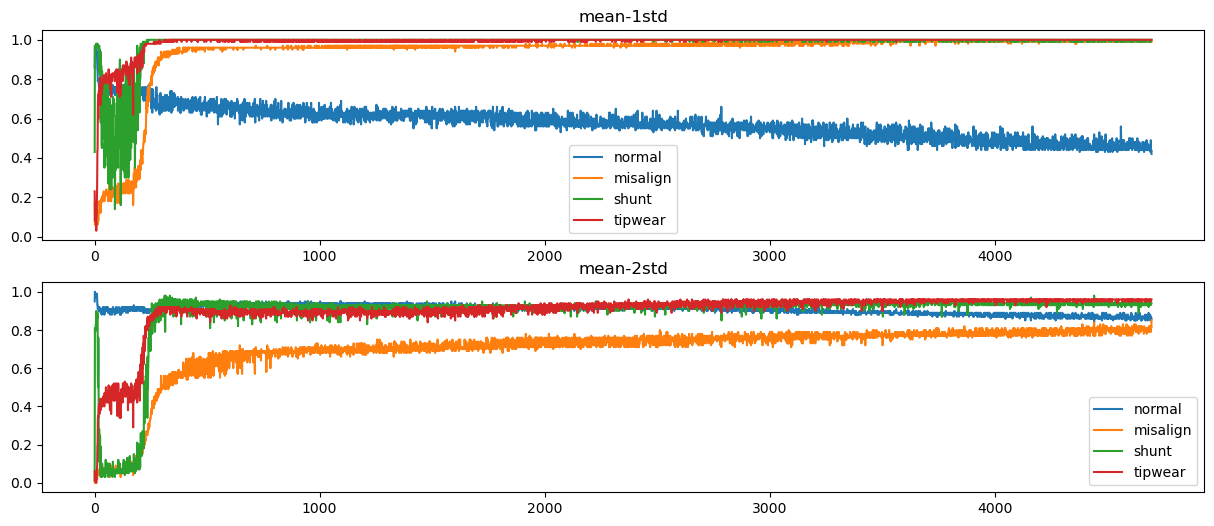

In [36]:
while True:
    s+=1
    history = autoencoder.fit(Train_Normal, Train_Normal,epochs=1,shuffle=True)
    
    encoded_train = autoencoder.encoder(Train_Normal).numpy()
    decoded_train = autoencoder.decoder(encoded_train).numpy()
    train_loss = tf.keras.losses.mae(decoded_train, Train_Normal)
    train_loss = np.sum(train_loss,axis=1)/2774

    encoded_normal = autoencoder.encoder(Test_Normal).numpy()
    decoded_normal = autoencoder.decoder(encoded_normal).numpy()
    normal_loss = tf.keras.losses.mae(decoded_normal, Test_Normal)
    normal_loss = np.sum(normal_loss,axis=1)/2774

    encoded_misalign = autoencoder.encoder(Test_Misalign).numpy()
    decoded_misalign = autoencoder.decoder(encoded_misalign).numpy()
    misalign_loss = tf.keras.losses.mae(decoded_misalign, Test_Misalign)
    misalign_loss = np.sum(misalign_loss,axis=1)/2774

    encoded_shunt = autoencoder.encoder(Test_Shunt).numpy()
    decoded_shunt = autoencoder.decoder(encoded_shunt).numpy()
    shunt_loss = tf.keras.losses.mae(decoded_shunt, Test_Shunt)
    shunt_loss = np.sum(shunt_loss,axis=1)/2774

    encoded_tipwear = autoencoder.encoder(Test_Tipwear).numpy()
    decoded_tipwear = autoencoder.decoder(encoded_tipwear).numpy()
    tipwear_loss = tf.keras.losses.mae(decoded_tipwear, Test_Tipwear)
    tipwear_loss = np.sum(tipwear_loss,axis=1)/2774
    
    
    threshold1 = np.mean(train_loss) + 1*np.std(train_loss)
    threshold2 = np.mean(train_loss) + 2*np.std(train_loss)
    
    s1=0
    s2=0
    for i in range(100):
        if normal_loss[i]<threshold1:
            s1+=1
        if normal_loss[i]<threshold2:
            s2+=1
    acc_normal1 = s1/100
    acc_normal2 = s2/100
    normal_acc1.append(acc_normal1)
    normal_acc2.append(acc_normal2)
    
    s1=0
    s2=0
    for i in range(100):
        if misalign_loss[i]>threshold1:
            s1+=1
        if misalign_loss[i]>threshold2:
            s2+=1
    acc_misalign1 = s1/100
    acc_misalign2 = s2/100
    misalign_acc1.append(acc_misalign1)
    misalign_acc2.append(acc_misalign2)
        
    s1=0
    s2=0
    for i in range(100):
        if shunt_loss[i]>threshold1:
            s1+=1
        if shunt_loss[i]>threshold2:
            s2+=1
    acc_shunt1 = s1/100
    acc_shunt2 = s2/100
    shunt_acc1.append(acc_shunt1)
    shunt_acc2.append(acc_shunt2)
        
    s1=0
    s2=0
    for i in range(100):
        if tipwear_loss[i]>threshold1:
            s1+=1
        if tipwear_loss[i]>threshold2:
            s2+=1
    acc_tipwear1 = s1/100
    acc_tipwear2 = s2/100
    tipwear_acc1.append(acc_tipwear1)
    tipwear_acc2.append(acc_tipwear2)
    
    print('epoch{}'.format(s))
    print(acc_normal1,acc_misalign1,acc_shunt1,acc_tipwear1)
    print(acc_normal2,acc_misalign2,acc_shunt2,acc_tipwear2)
   
        
    
    if (acc_normal1>0.84 and acc_misalign1>0.84 and acc_shunt1>0.85 and acc_tipwear1>0.84) or(acc_normal1>0.94 and acc_misalign1>0.94  and acc_tipwear1>0.94) or (acc_normal1>0.94 and  acc_shunt1>0.94 and acc_tipwear1>0.94) or (acc_normal1>0.94 and  acc_misalign1>0.94 and acc_shunt1>0.94):
        model = autoencoder
        model.save('./MLModels/CNN1D_retry_last%d'% s)
        break
    
    elif (acc_normal2>0.84 and acc_misalign2>0.84 and acc_shunt2>0.84 and acc_tipwear2>0.84) or(acc_normal2>0.94 and acc_misalign2>0.94  and acc_tipwear2>0.94) or (acc_normal2>0.94 and  acc_shunt2>0.94 and acc_tipwear2>0.94) or (acc_normal2>0.94 and  acc_misalign2>0.94 and acc_shunt2>0.94):
        model = autoencoder
        model.save('./MLModels/CNN1D_retry_last%d'% s)
        break
        
    elif s==5000:
        model = autoencoder
        model.save('./MLModels/CNN1D_retry_last%d'% s)
        break


plt.figure(figsize=(15,6))

ax = plt.subplot(2,1,1)
plt.plot(normal_acc1,label="normal")
plt.plot(misalign_acc1,label="misalign")
plt.plot(shunt_acc1,label="shunt")
plt.plot(tipwear_acc1,label="tipwear")
plt.title('mean-1std')
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(normal_acc2,label="normal")
plt.plot(misalign_acc2,label="misalign")
plt.plot(shunt_acc2,label="shunt")
plt.plot(tipwear_acc2,label="tipwear")
plt.title('mean-2std')
plt.legend()

In [37]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 924, 128)          1280      
                                                                 
 average_pooling1d_2 (Averag  (None, 308, 128)         0         
 ePooling1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 102, 32)           12320     
                                                                 
 average_pooling1d_3 (Averag  (None, 34, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 16)            1552      
                                                                 
Total params: 15,152
Trainable params: 15,152
Non-trai

# Reconstruction 시각화

In [38]:
encoded_train = autoencoder.encoder(Train_Normal).numpy()
decoded_train = autoencoder.decoder(encoded_train).numpy()

encoded_normal = autoencoder.encoder(Test_Normal).numpy()
decoded_normal = autoencoder.decoder(encoded_normal).numpy()
error_normal = Test_Normal - decoded_normal 

encoded_misalign = autoencoder.encoder(Test_Misalign).numpy()
decoded_misalign = autoencoder.decoder(encoded_misalign).numpy()
error_misalign = Test_Misalign - decoded_misalign 

encoded_shunt = autoencoder.encoder(Test_Shunt).numpy()
decoded_shunt = autoencoder.decoder(encoded_shunt).numpy()
error_shunt = Test_Shunt - decoded_shunt 

encoded_tipwear = autoencoder.encoder(Test_Tipwear).numpy()
decoded_tipwear = autoencoder.decoder(encoded_tipwear).numpy()
error_tipwear = Test_Tipwear - decoded_tipwear 

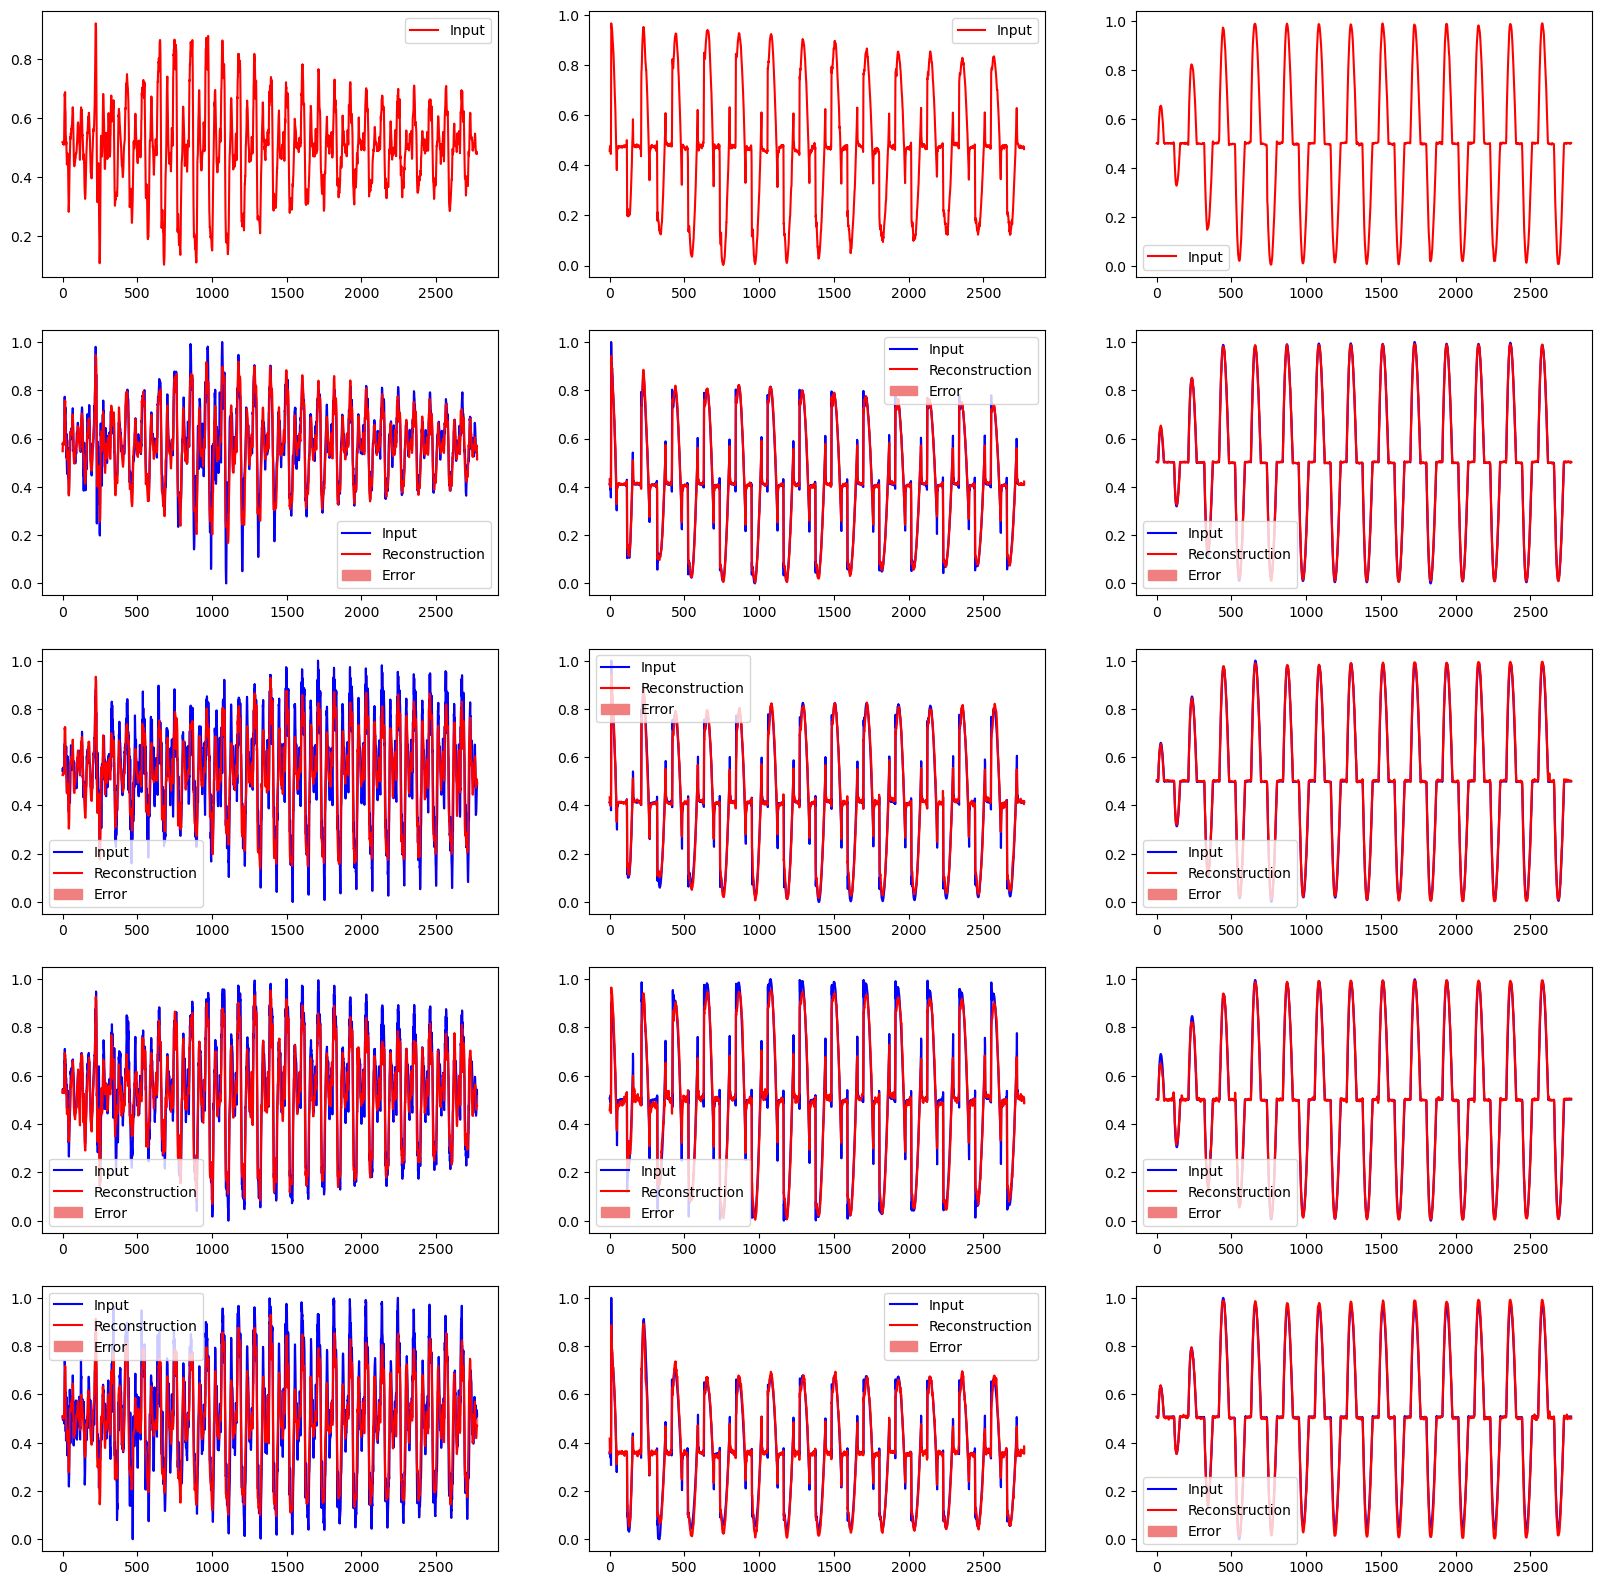

In [39]:
plt.figure(figsize=(20,20))

for i in range(3):
    show = plt.subplot(5,3,i+1)
    #plt.plot(np.array(Train_Normal[0]).T[i], 'b')
    plt.plot(np.array(decoded_train[0]).T[i], 'r')
    #plt.fill_between(np.arange(2774), np.array(decoded_train[0]).T[i],np.array(Train_Normal[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+4)
    plt.plot(np.array(Test_Normal[0]).T[i], 'b')
    plt.plot(np.array(decoded_normal[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_normal[0]).T[i],np.array(Test_Normal[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+7)
    plt.plot(np.array(Test_Misalign[0]).T[i], 'b')
    plt.plot(np.array(decoded_misalign[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_misalign[0]).T[i],np.array(Test_Misalign[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+10)
    plt.plot(np.array(Test_Shunt[0]).T[i], 'b')
    plt.plot(np.array(decoded_shunt[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_shunt[0]).T[i],np.array(Test_Shunt[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+13)
    plt.plot(np.array(Test_Tipwear[0]).T[i], 'b')
    plt.plot(np.array(decoded_tipwear[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_tipwear[0]).T[i],np.array(Test_Tipwear[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    
    

# 오류 발생 위치 확인

In [40]:
encoded_normal = autoencoder.encoder(Test_Normal).numpy()
decoded_normal = autoencoder.decoder(encoded_normal).numpy()
error_normal = Test_Normal - decoded_normal        
  

(0.0, 2774.0)

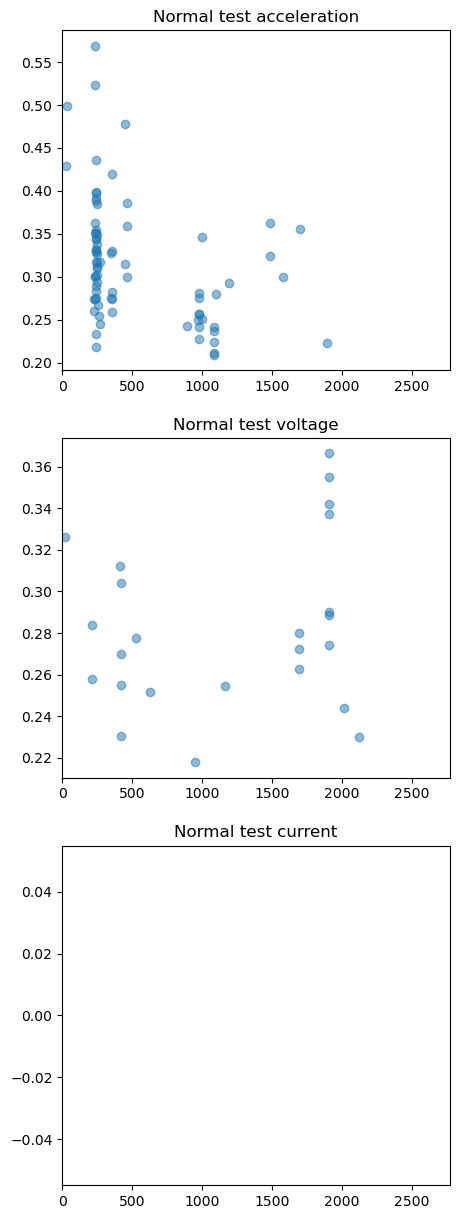

In [41]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_normal[i].T[0],error_normal[i].T[1],error_normal[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(5,15))
        
plt.subplot(3,1,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Normal test acceleration')
plt.xlim(0,2774)

plt.subplot(3,1,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Normal test voltage')
plt.xlim(0,2774)

plt.subplot(3,1,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Normal test current')
plt.xlim(0,2774)
    

    

(0.0, 2774.0)

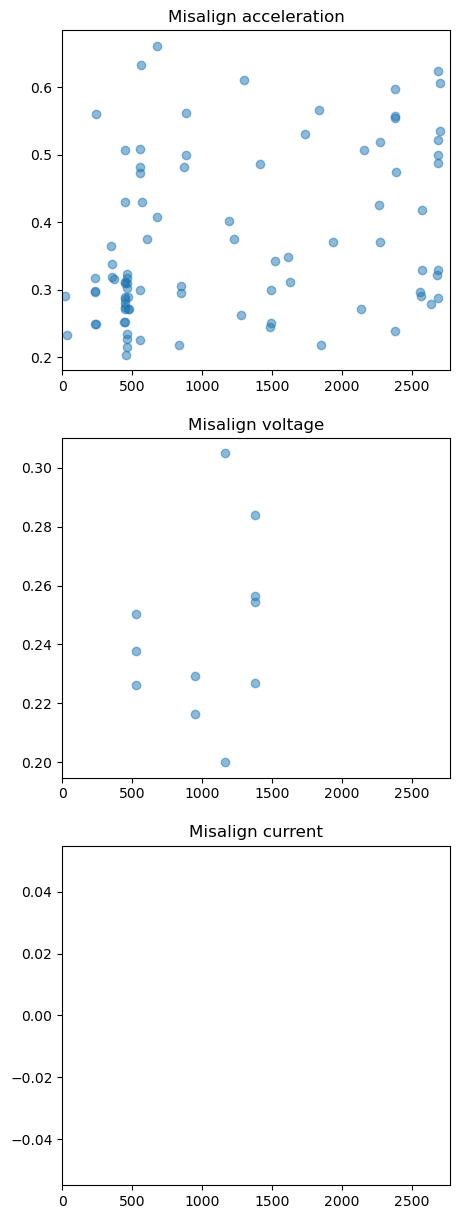

In [42]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_misalign[i].T[0],error_misalign[i].T[1],error_misalign[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(5,15))
        
plt.subplot(3,1,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Misalign acceleration')
plt.xlim(0,2774)

plt.subplot(3,1,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Misalign voltage')
plt.xlim(0,2774)

plt.subplot(3,1,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Misalign current')
plt.xlim(0,2774)

(0.0, 2774.0)

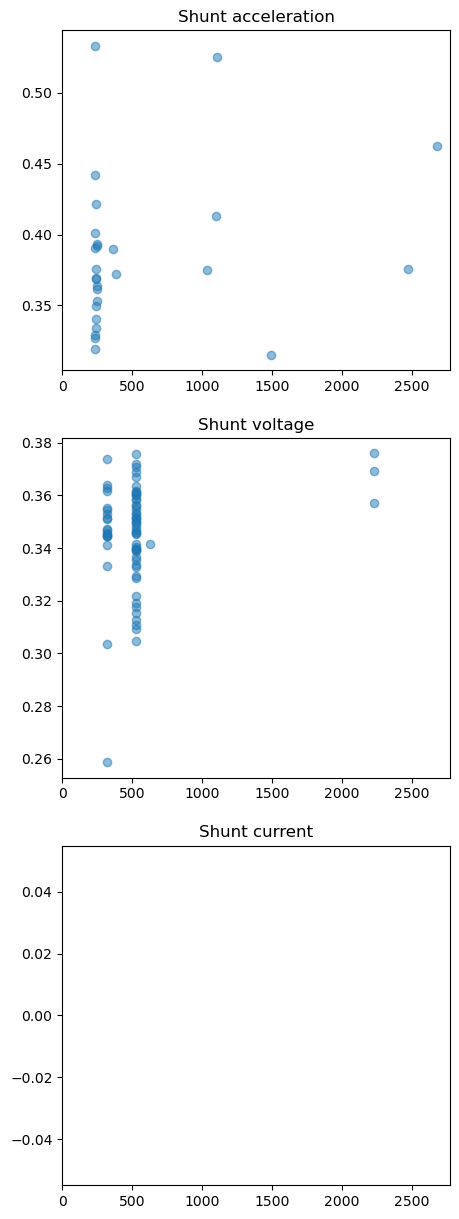

In [43]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_shunt[i].T[0],error_shunt[i].T[1],error_shunt[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(5,15))
        
plt.subplot(3,1,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Shunt acceleration')
plt.xlim(0,2774)

plt.subplot(3,1,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Shunt voltage')
plt.xlim(0,2774)

plt.subplot(3,1,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Shunt current')
plt.xlim(0,2774)

(0.0, 2774.0)

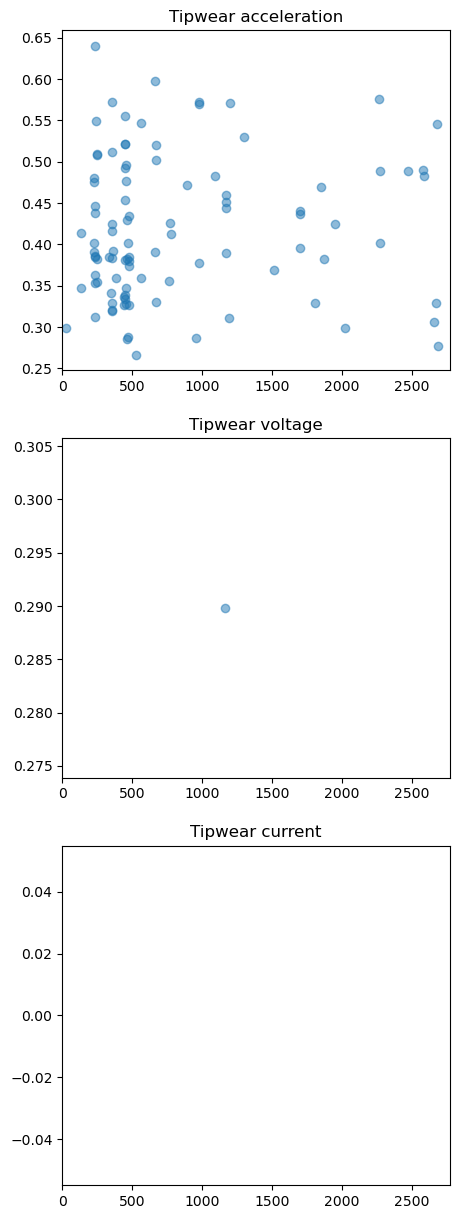

In [44]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_tipwear[i].T[0],error_tipwear[i].T[1],error_tipwear[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(5,15))
        
plt.subplot(3,1,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Tipwear acceleration')
plt.xlim(0,2774)

plt.subplot(3,1,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Tipwear voltage')
plt.xlim(0,2774)

plt.subplot(3,1,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Tipwear current')
plt.xlim(0,2774)